In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import (
    ResNet18_Weights, EfficientNet_B0_Weights,
    MobileNet_V3_Small_Weights, ViT_B_16_Weights
)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from PIL import Image
import os
from pathlib import Path
import time
import warnings
import copy
from tqdm.notebook import tqdm
import random

warnings.filterwarnings('ignore')

# Проверяем доступность GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Используемое устройство: {device}")
print(f"Версия PyTorch: {torch.__version__}")

# %% [markdown]
# ## 2. Загрузка и подготовка датасета

# %%
# Создадим искусственный датасет, имитирующий Garbage Classification
# В реальных условиях нужно скачать датасет с Kaggle

def create_synthetic_dataset():
    import shutil
    from torchvision.datasets import ImageFolder
    from torchvision.datasets.utils import download_and_extract_archive

    # Пробуем скачать датасет с мусором (TrashNet)
    dataset_url = "https://github.com/garythung/trashnet/raw/master/data/dataset-resized.zip"
    dataset_path = Path("./data")

    try:
        print("Пытаемся скачать TrashNet датасет...")
        if not dataset_path.exists():
            dataset_path.mkdir(parents=True)

        !wget -q {dataset_url} -O ./data/dataset.zip
        !unzip -q ./data/dataset.zip -d ./data/

        # Переименовываем папки для соответствия категориям
        trashnet_path = Path("./data/dataset-resized")

        if trashnet_path.exists():
            print(f"Датасет успешно скачан в {trashnet_path}")
            return trashnet_path

    except Exception as e:
        print(f"Не удалось скачать датасет: {e}")
        print("Создаем синтетический датасет из CIFAR-10...")

        # Используем CIFAR-10 как базовый датасет
        # И переименуем классы под категории мусора
        classes_mapping = {
            'airplane': 'plastic',
            'automobile': 'metal',
            'bird': 'paper',
            'cat': 'glass',
            'deer': 'cardboard',
            'dog': 'trash',
            'frog': 'plastic',
            'horse': 'metal',
            'ship': 'glass',
            'truck': 'trash'
        }

        # Создаем структуру директорий
        synthetic_path = Path("./data/synthetic_garbage")
        synthetic_path.mkdir(parents=True, exist_ok=True)

        for class_name in classes_mapping.values():
            (synthetic_path / class_name).mkdir(exist_ok=True)

        trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
        testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)

        def save_images(dataset, split_name):
            for i, (image, label_idx) in enumerate(dataset):
                if i >= 500:  # Ограничим размер для скорости
                    break

                original_class = trainset.classes[label_idx]
                new_class = classes_mapping[original_class]

                # Сохраняем изображение
                image_path = synthetic_path / new_class / f"{split_name}_{i}.png"
                image.save(image_path)

        save_images(trainset, "train")
        save_images(testset, "test")

        print(f"Создан синтетический датасет в {synthetic_path}")
        return synthetic_path

# Загружаем/создаем датасет
dataset_path = create_synthetic_dataset()

CLASSES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
NUM_CLASSES = len(CLASSES)

print(f"Классы для классификации: {CLASSES}")
print(f"Количество классов: {NUM_CLASSES}")

Используемое устройство: cuda
Версия PyTorch: 2.9.0+cu126
Пытаемся скачать TrashNet датасет...
Датасет успешно скачан в data/dataset-resized
Классы для классификации: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Количество классов: 6


cardboard: 403 изображений
glass: 501 изображений
metal: 410 изображений
paper: 594 изображений
plastic: 482 изображений
trash: 137 изображений
Всего изображений: 2527

Примеры изображений:


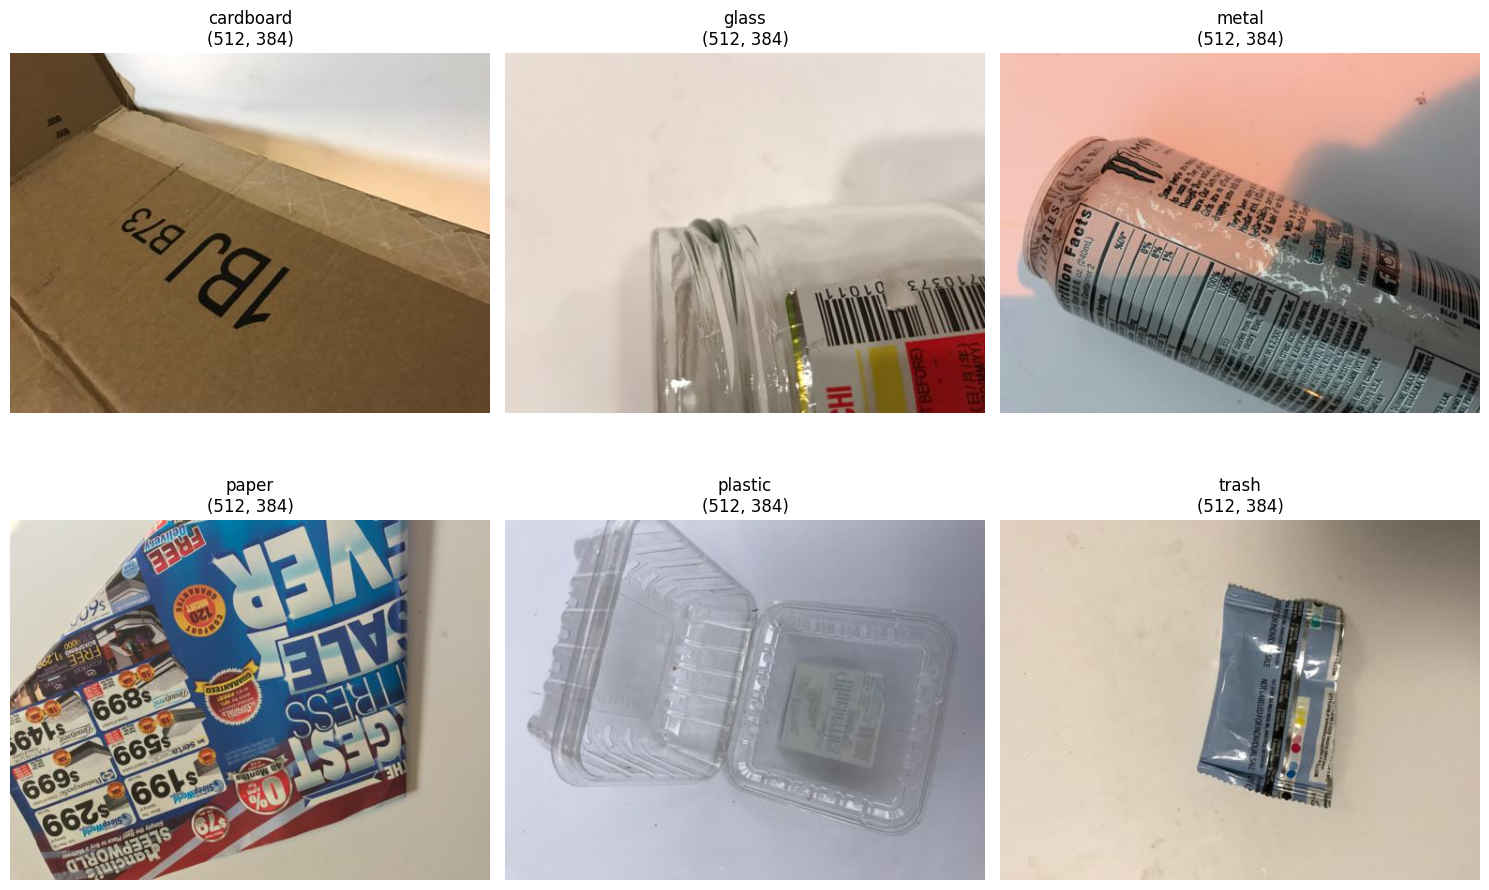

In [2]:
def explore_dataset(path):
    """Исследует структуру датасета"""
    path = Path(path)
    if not path.exists():
        print("Датасет не найден!")
        return

    total_images = 0
    for class_name in CLASSES:
        class_path = path / class_name
        if class_path.exists():
            images = list(class_path.glob("*.png")) + list(class_path.glob("*.jpg"))
            print(f"{class_name}: {len(images)} изображений")
            total_images += len(images)
        else:
            print(f"{class_name}: директория не найдена")

    print("=" * 50)
    print(f"Всего изображений: {total_images}")

    # Показываем примеры изображений
    print("\nПримеры изображений:")
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    for idx, class_name in enumerate(CLASSES):
        row = idx // 3
        col = idx % 3

        class_path = path / class_name
        if class_path.exists():
            images = list(class_path.glob("*.png")) + list(class_path.glob("*.jpg"))
            if images:
                img_path = images[0]
                img = Image.open(img_path)
                axes[row, col].imshow(img)
                axes[row, col].set_title(f"{class_name}\n{img.size}")
                axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

explore_dataset(dataset_path)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

Найдено классов: 6
Классы: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Размер тренировочной выборки: 1768
Размер валидационной выборки: 379
Размер тестовой выборки: 380
Размер батча изображений: torch.Size([32, 3, 224, 224])
Размер батча меток: torch.Size([32])


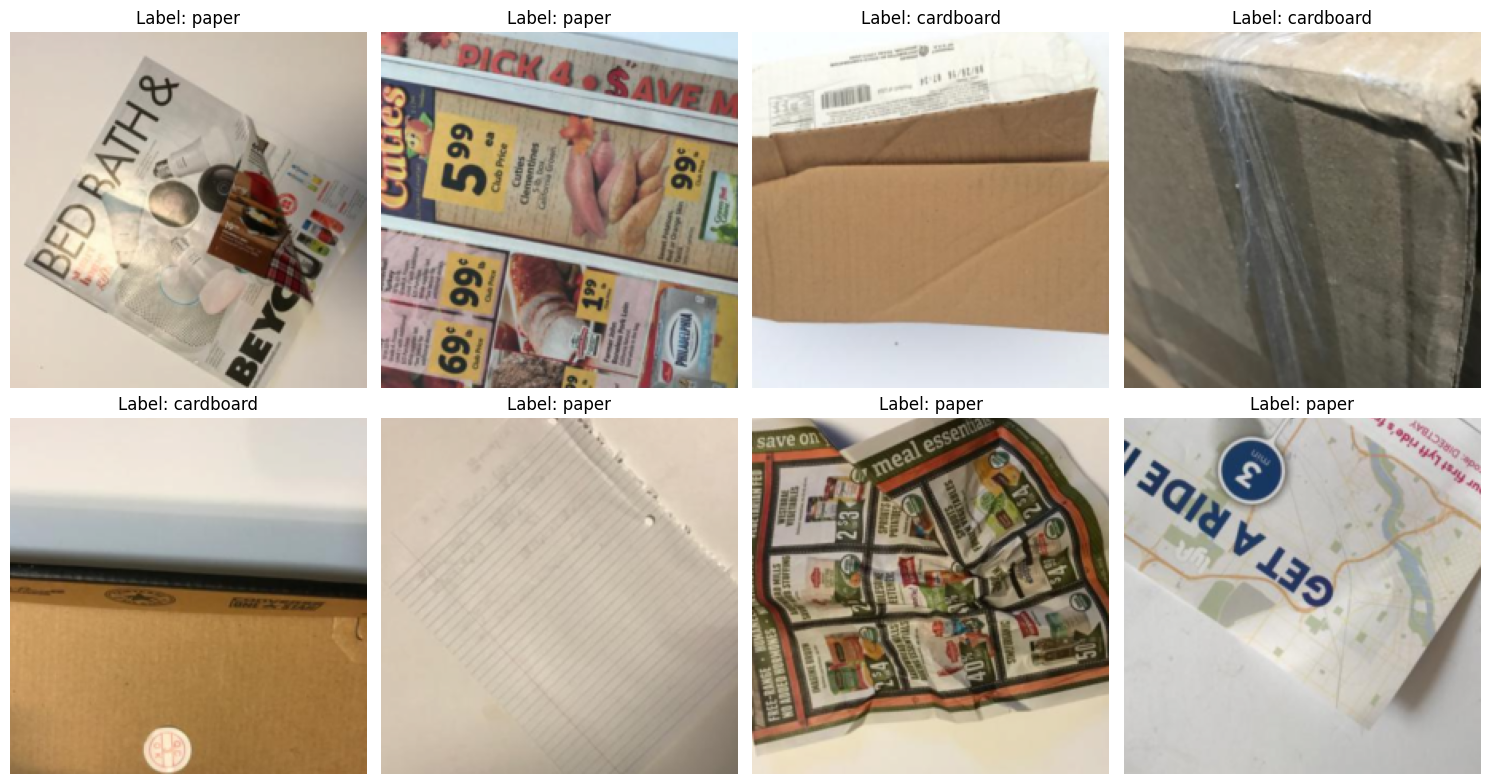

In [3]:
full_dataset = torchvision.datasets.ImageFolder(
    root=str(dataset_path),
    transform=data_transforms['train']
)

class_names = full_dataset.classes
print(f"Найдено классов: {len(class_names)}")
print(f"Классы: {class_names}")

class_to_idx = full_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

dataset_size = len(full_dataset)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

train_dataset.dataset.transform = data_transforms['train']
val_dataset.dataset.transform = data_transforms['val']
test_dataset.dataset.transform = data_transforms['test']

print(f"Размер тренировочной выборки: {len(train_dataset)}")
print(f"Размер валидационной выборки: {len(val_dataset)}")
print(f"Размер тестовой выборки: {len(test_dataset)}")

batch_size = 32

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=2
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=2
)

# Проверяем батч
images, labels = next(iter(train_loader))
print(f"Размер батча изображений: {images.shape}")
print(f"Размер батча меток: {labels.shape}")

# Исправленная функция визуализации
def imshow(inp, ax=None, title=None):
    """Визуализация тензора как изображения на указанной оси"""
    if ax is None:
        fig, ax = plt.subplots()

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    ax.imshow(inp)
    if title is not None:
        ax.set_title(title)
    ax.axis('off')

fig, axes = plt.subplots(2, 4, figsize=(15, 8))
axes = axes.flatten()

for i in range(min(8, len(images))):
    imshow(images[i], ax=axes[i], title=f"Label: {idx_to_class[labels[i].item()]}")

for i in range(len(images), 8):
    axes[i].axis('off')

plt.tight_layout()
plt.show()

In [4]:
def create_model(model_name, pretrained=True, freeze_backbone=False):

    model = None
    input_size = 224

    if model_name == 'resnet18':
        if pretrained:
            weights = ResNet18_Weights.IMAGENET1K_V1
            model = models.resnet18(weights=weights)
        else:
            model = models.resnet18(weights=None)

        num_features = model.fc.in_features
        model.fc = nn.Linear(num_features, NUM_CLASSES)

        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
            for param in model.fc.parameters():
                param.requires_grad = True

    elif model_name == 'efficientnet':
        if pretrained:
            weights = EfficientNet_B0_Weights.IMAGENET1K_V1
            model = models.efficientnet_b0(weights=weights)
        else:
            model = models.efficientnet_b0(weights=None)

        num_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(num_features, NUM_CLASSES)

        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
            for param in model.classifier.parameters():
                param.requires_grad = True

    elif model_name == 'mobilenet':
        if pretrained:
            weights = MobileNet_V3_Small_Weights.IMAGENET1K_V1
            model = models.mobilenet_v3_small(weights=weights)
        else:
            model = models.mobilenet_v3_small(weights=None)

        num_features = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(num_features, NUM_CLASSES)

        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
            for param in model.classifier.parameters():
                param.requires_grad = True

    elif model_name == 'vit':
        if pretrained:
            weights = ViT_B_16_Weights.IMAGENET1K_V1
            model = models.vit_b_16(weights=weights)
        else:
            model = models.vit_b_16(weights=None)

        num_features = model.heads.head.in_features
        model.heads.head = nn.Linear(num_features, NUM_CLASSES)

        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False
            for param in model.heads.parameters():
                param.requires_grad = True

    else:
        raise ValueError(f"Неизвестная модель: {model_name}")

    return model.to(device), input_size

def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler=None, num_epochs=10, model_name='model'):


    history = {
        'train_loss': [], 'train_acc': [], 'train_f1': [],
        'val_loss': [], 'val_acc': [], 'val_f1': []
    }

    best_model_wts = copy.deepcopy(model.state_dict())
    best_f1 = 0.0

    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        print('-' * 50)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
                dataloader = train_loader
            else:
                model.eval()
                dataloader = val_loader

            running_loss = 0.0
            running_corrects = 0
            all_preds = []
            all_labels = []

            for inputs, labels in tqdm(dataloader, desc=f'{phase}', leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

            # Вычисляем метрики для эпохи
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double() / len(dataloader.dataset)
            epoch_f1 = f1_score(all_labels, all_preds, average='macro')

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} F1: {epoch_f1:.4f}')

            # Сохраняем историю
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
                history['train_acc'].append(epoch_acc.item())
                history['train_f1'].append(epoch_f1)
            else:
                history['val_loss'].append(epoch_loss)
                history['val_acc'].append(epoch_acc.item())
                history['val_f1'].append(epoch_f1)

                # Сохраняем лучшую модель
                if epoch_f1 > best_f1:
                    best_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(model.state_dict())

        # Обновляем scheduler
        if scheduler is not None:
            scheduler.step()

    # Загружаем лучшие веса модели
    model.load_state_dict(best_model_wts)
    print(f'\nBest val F1: {best_f1:.4f}')

    return model, history

def evaluate_model(model, test_loader):
    """
    Оценивает модель на тестовом наборе
    """
    model.eval()

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Вычисляем метрики
    test_acc = np.mean(np.array(all_preds) == np.array(all_labels))
    test_f1 = f1_score(all_labels, all_preds, average='macro')

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Classification report
    report = classification_report(
        all_labels, all_preds,
        target_names=CLASSES,
        digits=4
    )

    return test_acc, test_f1, cm, report

In [5]:
NUM_EPOCHS = 20
LEARNING_RATE = 0.05

# Список моделей для экспериментов
models_to_test = ['resnet18', 'efficientnet', 'mobilenet', 'vit']

# Словари для хранения результатов
results = {
    'from_scratch': {},
    'transfer_learning': {}
}

histories = {
    'from_scratch': {},
    'transfer_learning': {}
}

# %%
# Эксперимент 1: Обучение с нуля (со случайными весами)
print("=" * 60)
print("ЭКСПЕРИМЕНТ 1: ОБУЧЕНИЕ С НУЛЯ")
print("=" * 60)

for model_name in models_to_test:
    print(f"\n\nМодель: {model_name.upper()} (с нуля)")
    print("-" * 40)

    # Создаем модель без предобученных весов
    model, _ = create_model(model_name, pretrained=False, freeze_backbone=False)

    # Определяем функцию потерь и оптимизатор
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

    # Обучаем модель
    model, history = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler,
        num_epochs=NUM_EPOCHS,
        model_name=model_name
    )

    # Оцениваем на тестовом наборе
    test_acc, test_f1, cm, report = evaluate_model(model, test_loader)

    print(f"\nРезультаты на тестовом наборе:")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Macro F1-score: {test_f1:.4f}")
    print("\nClassification Report:")
    print(report)

    # Сохраняем результаты
    results['from_scratch'][model_name] = {
        'accuracy': test_acc,
        'f1_score': test_f1
    }
    histories['from_scratch'][model_name] = history

    # Освобождаем память
    del model
    torch.cuda.empty_cache()

# %%
# Эксперимент 2: Transfer Learning (с предобученными весами)
print("\n" + "=" * 60)
print("ЭКСПЕРИМЕНТ 2: TRANSFER LEARNING")
print("=" * 60)

for model_name in models_to_test:
    print(f"\n\nМодель: {model_name.upper()} (transfer learning)")
    print("-" * 40)

    # Создаем модель с предобученными весами и замороженным backbone
    model, _ = create_model(model_name, pretrained=True, freeze_backbone=True)

    # Используем меньшую скорость обучения для fine-tuning
    criterion = nn.CrossEntropyLoss()

    # Настраиваем оптимизатор только для обучаемых параметров
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.Adam(trainable_params, lr=LEARNING_RATE * 0.1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    # Обучаем модель
    model, history = train_model(
        model, train_loader, val_loader,
        criterion, optimizer, scheduler,
        num_epochs=NUM_EPOCHS,
        model_name=model_name
    )

    # Оцениваем на тестовом наборе
    test_acc, test_f1, cm, report = evaluate_model(model, test_loader)

    print(f"\nРезультаты на тестовом наборе:")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Macro F1-score: {test_f1:.4f}")
    print("\nClassification Report:")
    print(report)

    # Сохраняем результаты
    results['transfer_learning'][model_name] = {
        'accuracy': test_acc,
        'f1_score': test_f1
    }
    histories['transfer_learning'][model_name] = history

    # Освобождаем память
    del model
    torch.cuda.empty_cache()

ЭКСПЕРИМЕНТ 1: ОБУЧЕНИЕ С НУЛЯ


Модель: RESNET18 (с нуля)
----------------------------------------

Epoch 1/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 2.6691 Acc: 0.3343 F1: 0.2628


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.7854 Acc: 0.3879 F1: 0.2721

Epoch 2/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.4780 Acc: 0.4084 F1: 0.3160


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6387 Acc: 0.3905 F1: 0.2672

Epoch 3/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.4587 Acc: 0.4186 F1: 0.3315


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.4716 Acc: 0.4142 F1: 0.3311

Epoch 4/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.3886 Acc: 0.4553 F1: 0.3831


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.5043 Acc: 0.4512 F1: 0.3776

Epoch 5/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.3938 Acc: 0.4514 F1: 0.3855


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.7796 Acc: 0.4037 F1: 0.3487

Epoch 6/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.3417 Acc: 0.4943 F1: 0.4237


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.4156 Acc: 0.4459 F1: 0.3830

Epoch 7/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.2631 Acc: 0.5271 F1: 0.4536


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.3540 Acc: 0.4881 F1: 0.4306

Epoch 8/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.1715 Acc: 0.5436 F1: 0.4674


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.2183 Acc: 0.5541 F1: 0.4848

Epoch 9/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.1595 Acc: 0.5554 F1: 0.4762


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.2093 Acc: 0.5673 F1: 0.4976

Epoch 10/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.1236 Acc: 0.5764 F1: 0.4954


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.1850 Acc: 0.5778 F1: 0.5032

Epoch 11/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.1152 Acc: 0.5667 F1: 0.4861


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.1730 Acc: 0.5726 F1: 0.5081

Epoch 12/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.1023 Acc: 0.5764 F1: 0.4930


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.1325 Acc: 0.5989 F1: 0.5288

Epoch 13/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.0706 Acc: 0.5979 F1: 0.5247


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.1440 Acc: 0.5646 F1: 0.4930

Epoch 14/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.0287 Acc: 0.6052 F1: 0.5297


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.0685 Acc: 0.6412 F1: 0.5861

Epoch 15/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.0087 Acc: 0.6210 F1: 0.5489


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.0658 Acc: 0.6385 F1: 0.5983

Epoch 16/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.9967 Acc: 0.6307 F1: 0.5584


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.0617 Acc: 0.6201 F1: 0.5788

Epoch 17/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.9888 Acc: 0.6284 F1: 0.5487


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.0585 Acc: 0.6306 F1: 0.5784

Epoch 18/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.9811 Acc: 0.6363 F1: 0.5689


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.0362 Acc: 0.6412 F1: 0.6046

Epoch 19/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.9830 Acc: 0.6352 F1: 0.5688


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.0642 Acc: 0.6201 F1: 0.5855

Epoch 20/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.9823 Acc: 0.6278 F1: 0.5609


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.0382 Acc: 0.6332 F1: 0.5919

Best val F1: 0.6046


Testing:   0%|          | 0/12 [00:00<?, ?it/s]


Результаты на тестовом наборе:
Accuracy: 0.6868
Macro F1-score: 0.6353

Classification Report:
              precision    recall  f1-score   support

   cardboard     0.8507    0.8507    0.8507        67
       glass     0.5521    0.7910    0.6503        67
       metal     0.6275    0.5333    0.5766        60
       paper     0.6809    0.7805    0.7273        82
     plastic     0.7812    0.6250    0.6944        80
       trash     0.6250    0.2083    0.3125        24

    accuracy                         0.6868       380
   macro avg     0.6862    0.6315    0.6353       380
weighted avg     0.6973    0.6868    0.6786       380



Модель: EFFICIENTNET (с нуля)
----------------------------------------

Epoch 1/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 4.2839 Acc: 0.2104 F1: 0.1833


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 17.3290 Acc: 0.2348 F1: 0.1316

Epoch 2/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.8914 Acc: 0.2579 F1: 0.2222


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 2.0329 Acc: 0.2058 F1: 0.0853

Epoch 3/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.6934 Acc: 0.2936 F1: 0.2523


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.7162 Acc: 0.2718 F1: 0.1587

Epoch 4/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.6640 Acc: 0.3100 F1: 0.2650


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6668 Acc: 0.2850 F1: 0.1666

Epoch 5/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.6560 Acc: 0.3162 F1: 0.2552


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.7673 Acc: 0.2850 F1: 0.2162

Epoch 6/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5779 Acc: 0.3541 F1: 0.2938


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.7013 Acc: 0.3747 F1: 0.3224

Epoch 7/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5321 Acc: 0.3914 F1: 0.3155


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.5640 Acc: 0.3879 F1: 0.2599

Epoch 8/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.4207 Acc: 0.4485 F1: 0.3354


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.4125 Acc: 0.4512 F1: 0.3227

Epoch 9/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.3773 Acc: 0.4666 F1: 0.3517


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.4068 Acc: 0.4723 F1: 0.3604

Epoch 10/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.3781 Acc: 0.4525 F1: 0.3449


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.3799 Acc: 0.4644 F1: 0.3348

Epoch 11/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.3507 Acc: 0.4779 F1: 0.3593


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.3874 Acc: 0.4776 F1: 0.3550

Epoch 12/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.3437 Acc: 0.4785 F1: 0.3737


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.3711 Acc: 0.4617 F1: 0.3372

Epoch 13/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.3221 Acc: 0.4915 F1: 0.3804


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.3790 Acc: 0.4828 F1: 0.3846

Epoch 14/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.3186 Acc: 0.4870 F1: 0.3766


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.3675 Acc: 0.4565 F1: 0.3204

Epoch 15/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.2953 Acc: 0.4847 F1: 0.3561


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.3507 Acc: 0.4908 F1: 0.3836

Epoch 16/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.2976 Acc: 0.5000 F1: 0.3856


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.3306 Acc: 0.4987 F1: 0.3953

Epoch 17/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.2722 Acc: 0.5068 F1: 0.3905


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.3318 Acc: 0.4855 F1: 0.3833

Epoch 18/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.2746 Acc: 0.5079 F1: 0.3952


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.3411 Acc: 0.4881 F1: 0.3816

Epoch 19/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.2789 Acc: 0.5204 F1: 0.4057


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.3416 Acc: 0.4960 F1: 0.3944

Epoch 20/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.2575 Acc: 0.5090 F1: 0.3930


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.3299 Acc: 0.5040 F1: 0.4102

Best val F1: 0.4102


Testing:   0%|          | 0/12 [00:00<?, ?it/s]


Результаты на тестовом наборе:
Accuracy: 0.5737
Macro F1-score: 0.4521

Classification Report:
              precision    recall  f1-score   support

   cardboard     0.8358    0.8358    0.8358        67
       glass     0.4070    0.5224    0.4575        67
       metal     0.2353    0.0667    0.1039        60
       paper     0.5772    0.8659    0.6927        82
     plastic     0.5977    0.6500    0.6228        80
       trash     0.0000    0.0000    0.0000        24

    accuracy                         0.5737       380
   macro avg     0.4422    0.4901    0.4521       380
weighted avg     0.5067    0.5737    0.5250       380



Модель: MOBILENET (с нуля)
----------------------------------------

Epoch 1/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 8.8132 Acc: 0.2025 F1: 0.1866


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 3616015.9433 Acc: 0.1425 F1: 0.0416

Epoch 2/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.7519 Acc: 0.2500 F1: 0.2009


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 119.1689 Acc: 0.1478 F1: 0.0528

Epoch 3/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.6767 Acc: 0.2557 F1: 0.1969


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 3.6681 Acc: 0.2322 F1: 0.1845

Epoch 4/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.6549 Acc: 0.2811 F1: 0.2069


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6959 Acc: 0.2850 F1: 0.2221

Epoch 5/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.6870 Acc: 0.2489 F1: 0.1707


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6776 Acc: 0.2639 F1: 0.1387

Epoch 6/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.6564 Acc: 0.2743 F1: 0.2286


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 2.3606 Acc: 0.1609 F1: 0.0781

Epoch 7/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.6391 Acc: 0.2777 F1: 0.2189


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.7206 Acc: 0.2718 F1: 0.1335

Epoch 8/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.6171 Acc: 0.2873 F1: 0.1745


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6213 Acc: 0.3140 F1: 0.2108

Epoch 9/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5827 Acc: 0.3167 F1: 0.2138


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6106 Acc: 0.3219 F1: 0.2258

Epoch 10/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5744 Acc: 0.3184 F1: 0.2226


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.5995 Acc: 0.3377 F1: 0.2262

Epoch 11/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5830 Acc: 0.3066 F1: 0.2126


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.5939 Acc: 0.3325 F1: 0.2319

Epoch 12/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5730 Acc: 0.3196 F1: 0.2304


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.5803 Acc: 0.3193 F1: 0.2394

Epoch 13/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5672 Acc: 0.3167 F1: 0.2434


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.5909 Acc: 0.3509 F1: 0.2546

Epoch 14/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5437 Acc: 0.3388 F1: 0.2373


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.5759 Acc: 0.3668 F1: 0.2521

Epoch 15/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5503 Acc: 0.3292 F1: 0.2406


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.5630 Acc: 0.3483 F1: 0.2430

Epoch 16/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5366 Acc: 0.3354 F1: 0.2562


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.5577 Acc: 0.3509 F1: 0.2444

Epoch 17/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5349 Acc: 0.3518 F1: 0.2739


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.5556 Acc: 0.3879 F1: 0.2985

Epoch 18/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5336 Acc: 0.3490 F1: 0.2715


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.5544 Acc: 0.3694 F1: 0.2923

Epoch 19/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5220 Acc: 0.3580 F1: 0.2772


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.5531 Acc: 0.3720 F1: 0.2946

Epoch 20/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5129 Acc: 0.3676 F1: 0.2860


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.5489 Acc: 0.3668 F1: 0.2905

Best val F1: 0.2985


Testing:   0%|          | 0/12 [00:00<?, ?it/s]


Результаты на тестовом наборе:
Accuracy: 0.3947
Macro F1-score: 0.3068

Classification Report:
              precision    recall  f1-score   support

   cardboard     0.6622    0.7313    0.6950        67
       glass     0.3390    0.2985    0.3175        67
       metal     0.0000    0.0000    0.0000        60
       paper     0.2273    0.4268    0.2966        82
     plastic     0.4946    0.5750    0.5318        80
       trash     0.0000    0.0000    0.0000        24

    accuracy                         0.3947       380
   macro avg     0.2872    0.3386    0.3068       380
weighted avg     0.3297    0.3947    0.3545       380



Модель: VIT (с нуля)
----------------------------------------

Epoch 1/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 10.8514 Acc: 0.1997 F1: 0.1701


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 2.1186 Acc: 0.1847 F1: 0.0894

Epoch 2/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.7504 Acc: 0.2449 F1: 0.1855


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.7382 Acc: 0.2296 F1: 0.1023

Epoch 3/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.7191 Acc: 0.2178 F1: 0.1741


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.7398 Acc: 0.2454 F1: 0.0658

Epoch 4/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.7645 Acc: 0.2234 F1: 0.1582


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.7100 Acc: 0.2058 F1: 0.1101

Epoch 5/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.7255 Acc: 0.2472 F1: 0.1961


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.9103 Acc: 0.1979 F1: 0.1183

Epoch 6/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.6895 Acc: 0.2404 F1: 0.1904


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6861 Acc: 0.2427 F1: 0.0729

Epoch 7/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.6424 Acc: 0.2596 F1: 0.2147


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.7434 Acc: 0.2058 F1: 0.1415

Epoch 8/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5985 Acc: 0.2704 F1: 0.2153


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6383 Acc: 0.2955 F1: 0.2468

Epoch 9/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5882 Acc: 0.2856 F1: 0.2246


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6311 Acc: 0.2982 F1: 0.2302

Epoch 10/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5840 Acc: 0.2958 F1: 0.2411


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6152 Acc: 0.3245 F1: 0.2101

Epoch 11/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5777 Acc: 0.2890 F1: 0.2190


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6191 Acc: 0.3219 F1: 0.2482

Epoch 12/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5764 Acc: 0.2834 F1: 0.2170


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6164 Acc: 0.3193 F1: 0.2402

Epoch 13/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5706 Acc: 0.2947 F1: 0.2329


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6188 Acc: 0.3245 F1: 0.2467

Epoch 14/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5724 Acc: 0.2964 F1: 0.2245


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6236 Acc: 0.3008 F1: 0.2249

Epoch 15/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5613 Acc: 0.2958 F1: 0.2281


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6117 Acc: 0.3061 F1: 0.2340

Epoch 16/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5605 Acc: 0.3026 F1: 0.2332


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6087 Acc: 0.3061 F1: 0.2323

Epoch 17/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5597 Acc: 0.3071 F1: 0.2334


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6170 Acc: 0.2982 F1: 0.2267

Epoch 18/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5614 Acc: 0.3037 F1: 0.2321


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6161 Acc: 0.3061 F1: 0.2327

Epoch 19/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5593 Acc: 0.2998 F1: 0.2301


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6170 Acc: 0.3008 F1: 0.2282

Epoch 20/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.5582 Acc: 0.3003 F1: 0.2290


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 1.6152 Acc: 0.3140 F1: 0.2407

Best val F1: 0.2482


Testing:   0%|          | 0/12 [00:00<?, ?it/s]


Результаты на тестовом наборе:
Accuracy: 0.3132
Macro F1-score: 0.2423

Classification Report:
              precision    recall  f1-score   support

   cardboard     0.4516    0.6269    0.5250        67
       glass     0.2526    0.3582    0.2963        67
       metal     0.0000    0.0000    0.0000        60
       paper     0.1774    0.2683    0.2136        82
     plastic     0.4559    0.3875    0.4189        80
       trash     0.0000    0.0000    0.0000        24

    accuracy                         0.3132       380
   macro avg     0.2229    0.2735    0.2423       380
weighted avg     0.2584    0.3132    0.2791       380


ЭКСПЕРИМЕНТ 2: TRANSFER LEARNING


Модель: RESNET18 (transfer learning)
----------------------------------------
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 177MB/s]



Epoch 1/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.1499 Acc: 0.5707 F1: 0.5243


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.6713 Acc: 0.7704 F1: 0.7420

Epoch 2/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.6337 Acc: 0.7822 F1: 0.7571


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.6116 Acc: 0.7678 F1: 0.7368

Epoch 3/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.5509 Acc: 0.7952 F1: 0.7715


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.8109 Acc: 0.7124 F1: 0.6990

Epoch 4/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.5120 Acc: 0.8054 F1: 0.7849


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5835 Acc: 0.7784 F1: 0.7565

Epoch 5/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.5044 Acc: 0.8162 F1: 0.7964


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5748 Acc: 0.7863 F1: 0.7637

Epoch 6/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3541 Acc: 0.8812 F1: 0.8666


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5573 Acc: 0.8100 F1: 0.7794

Epoch 7/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3542 Acc: 0.8767 F1: 0.8653


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5720 Acc: 0.7968 F1: 0.7642

Epoch 8/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3393 Acc: 0.8840 F1: 0.8716


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5525 Acc: 0.8047 F1: 0.7709

Epoch 9/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3281 Acc: 0.8824 F1: 0.8687


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5569 Acc: 0.8074 F1: 0.7826

Epoch 10/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3500 Acc: 0.8801 F1: 0.8694


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5455 Acc: 0.8127 F1: 0.7893

Epoch 11/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3365 Acc: 0.8807 F1: 0.8733


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5444 Acc: 0.8153 F1: 0.7979

Epoch 12/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3251 Acc: 0.8897 F1: 0.8869


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5433 Acc: 0.8127 F1: 0.7936

Epoch 13/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3232 Acc: 0.8931 F1: 0.8835


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5435 Acc: 0.8074 F1: 0.7833

Epoch 14/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3186 Acc: 0.8925 F1: 0.8844


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5449 Acc: 0.8206 F1: 0.7959

Epoch 15/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3216 Acc: 0.8897 F1: 0.8821


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5595 Acc: 0.8100 F1: 0.7858

Epoch 16/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3330 Acc: 0.8920 F1: 0.8815


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5558 Acc: 0.7995 F1: 0.7763

Epoch 17/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3242 Acc: 0.8897 F1: 0.8760


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5399 Acc: 0.8074 F1: 0.7744

Epoch 18/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3230 Acc: 0.8914 F1: 0.8821


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5553 Acc: 0.8153 F1: 0.7904

Epoch 19/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3289 Acc: 0.8863 F1: 0.8776


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5504 Acc: 0.8153 F1: 0.7906

Epoch 20/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3297 Acc: 0.8852 F1: 0.8770


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5467 Acc: 0.8127 F1: 0.7816

Best val F1: 0.7979


Testing:   0%|          | 0/12 [00:00<?, ?it/s]


Результаты на тестовом наборе:
Accuracy: 0.8184
Macro F1-score: 0.7867

Classification Report:
              precision    recall  f1-score   support

   cardboard     0.9104    0.9104    0.9104        67
       glass     0.7324    0.7761    0.7536        67
       metal     0.7903    0.8167    0.8033        60
       paper     0.8795    0.8902    0.8848        82
     plastic     0.8205    0.8000    0.8101        80
       trash     0.6316    0.5000    0.5581        24

    accuracy                         0.8184       380
   macro avg     0.7941    0.7822    0.7867       380
weighted avg     0.8169    0.8184    0.8170       380



Модель: EFFICIENTNET (transfer learning)
----------------------------------------
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 167MB/s]



Epoch 1/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.9245 Acc: 0.6816 F1: 0.6350


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5966 Acc: 0.7916 F1: 0.7532

Epoch 2/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.5467 Acc: 0.8071 F1: 0.7847


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5939 Acc: 0.7942 F1: 0.7508

Epoch 3/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.4852 Acc: 0.8331 F1: 0.8051


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5092 Acc: 0.8311 F1: 0.7850

Epoch 4/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.4232 Acc: 0.8529 F1: 0.8380


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5233 Acc: 0.8259 F1: 0.8060

Epoch 5/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3985 Acc: 0.8626 F1: 0.8424


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5229 Acc: 0.8232 F1: 0.7903

Epoch 6/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3645 Acc: 0.8733 F1: 0.8761


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5014 Acc: 0.8259 F1: 0.7985

Epoch 7/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3117 Acc: 0.9044 F1: 0.9024


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5136 Acc: 0.8364 F1: 0.8181

Epoch 8/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3169 Acc: 0.8959 F1: 0.8867


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5270 Acc: 0.8311 F1: 0.8050

Epoch 9/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3236 Acc: 0.8925 F1: 0.8799


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5102 Acc: 0.8179 F1: 0.7908

Epoch 10/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3210 Acc: 0.8891 F1: 0.8805


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5545 Acc: 0.8153 F1: 0.7891

Epoch 11/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.2935 Acc: 0.9055 F1: 0.8933


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5207 Acc: 0.8285 F1: 0.8039

Epoch 12/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3055 Acc: 0.8954 F1: 0.8832


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5181 Acc: 0.8206 F1: 0.7967

Epoch 13/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.2893 Acc: 0.9027 F1: 0.8963


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5196 Acc: 0.8232 F1: 0.7947

Epoch 14/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.2922 Acc: 0.9038 F1: 0.8978


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5198 Acc: 0.8311 F1: 0.8085

Epoch 15/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3138 Acc: 0.8937 F1: 0.8894


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.4975 Acc: 0.8391 F1: 0.8145

Epoch 16/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.2993 Acc: 0.8982 F1: 0.8912


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5111 Acc: 0.8232 F1: 0.7944

Epoch 17/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3033 Acc: 0.8920 F1: 0.8836


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5012 Acc: 0.8311 F1: 0.8049

Epoch 18/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3042 Acc: 0.8993 F1: 0.8947


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5191 Acc: 0.8338 F1: 0.8140

Epoch 19/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.2914 Acc: 0.9146 F1: 0.9127


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5196 Acc: 0.8285 F1: 0.8069

Epoch 20/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3082 Acc: 0.8976 F1: 0.8903


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5056 Acc: 0.8364 F1: 0.8147

Best val F1: 0.8181


Testing:   0%|          | 0/12 [00:00<?, ?it/s]


Результаты на тестовом наборе:
Accuracy: 0.8237
Macro F1-score: 0.7638

Classification Report:
              precision    recall  f1-score   support

   cardboard     0.8806    0.8806    0.8806        67
       glass     0.8116    0.8358    0.8235        67
       metal     0.8060    0.9000    0.8504        60
       paper     0.8409    0.9024    0.8706        82
     plastic     0.8101    0.8000    0.8050        80
       trash     0.6000    0.2500    0.3529        24

    accuracy                         0.8237       380
   macro avg     0.7915    0.7615    0.7638       380
weighted avg     0.8155    0.8237    0.8144       380



Модель: MOBILENET (transfer learning)
----------------------------------------
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth


100%|██████████| 9.83M/9.83M [00:00<00:00, 74.4MB/s]


Epoch 1/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.0234 Acc: 0.6448 F1: 0.6056


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.8312 Acc: 0.7098 F1: 0.6418

Epoch 2/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.6429 Acc: 0.7681 F1: 0.7441


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.6051 Acc: 0.7889 F1: 0.7386

Epoch 3/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.4655 Acc: 0.8348 F1: 0.8218


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5747 Acc: 0.8127 F1: 0.7770

Epoch 4/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.4182 Acc: 0.8535 F1: 0.8348


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.6249 Acc: 0.7968 F1: 0.7681

Epoch 5/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.3575 Acc: 0.8773 F1: 0.8589


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.6053 Acc: 0.8127 F1: 0.7770

Epoch 6/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.2007 Acc: 0.9304 F1: 0.9214


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5160 Acc: 0.8153 F1: 0.7847

Epoch 7/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.1441 Acc: 0.9542 F1: 0.9492


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5246 Acc: 0.8259 F1: 0.7997

Epoch 8/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.1035 Acc: 0.9695 F1: 0.9672


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5177 Acc: 0.8311 F1: 0.7990

Epoch 9/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0995 Acc: 0.9717 F1: 0.9671


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5079 Acc: 0.8311 F1: 0.7988

Epoch 10/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0976 Acc: 0.9723 F1: 0.9700


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5173 Acc: 0.8311 F1: 0.8001

Epoch 11/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0864 Acc: 0.9762 F1: 0.9717


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5095 Acc: 0.8364 F1: 0.8050

Epoch 12/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0775 Acc: 0.9819 F1: 0.9812


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5060 Acc: 0.8364 F1: 0.8043

Epoch 13/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0798 Acc: 0.9791 F1: 0.9770


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5060 Acc: 0.8364 F1: 0.8043

Epoch 14/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0787 Acc: 0.9830 F1: 0.9821


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5086 Acc: 0.8285 F1: 0.7933

Epoch 15/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0769 Acc: 0.9751 F1: 0.9710


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5077 Acc: 0.8338 F1: 0.7982

Epoch 16/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0782 Acc: 0.9802 F1: 0.9797


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5076 Acc: 0.8338 F1: 0.7982

Epoch 17/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0846 Acc: 0.9791 F1: 0.9786


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5089 Acc: 0.8338 F1: 0.7982

Epoch 18/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0726 Acc: 0.9825 F1: 0.9823


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5086 Acc: 0.8338 F1: 0.7982

Epoch 19/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0690 Acc: 0.9853 F1: 0.9826


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5065 Acc: 0.8338 F1: 0.7982

Epoch 20/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0851 Acc: 0.9757 F1: 0.9752


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5065 Acc: 0.8338 F1: 0.7982

Best val F1: 0.8050


Testing:   0%|          | 0/12 [00:00<?, ?it/s]


Результаты на тестовом наборе:
Accuracy: 0.8737
Macro F1-score: 0.8515

Classification Report:
              precision    recall  f1-score   support

   cardboard     0.9394    0.9254    0.9323        67
       glass     0.8026    0.9104    0.8531        67
       metal     0.8594    0.9167    0.8871        60
       paper     0.8929    0.9146    0.9036        82
     plastic     0.8904    0.8125    0.8497        80
       trash     0.8235    0.5833    0.6829        24

    accuracy                         0.8737       380
   macro avg     0.8680    0.8438    0.8515       380
weighted avg     0.8750    0.8737    0.8719       380



Модель: VIT (transfer learning)
----------------------------------------
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


100%|██████████| 330M/330M [00:02<00:00, 161MB/s]



Epoch 1/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.5616 Acc: 0.8071 F1: 0.7705


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3809 Acc: 0.8522 F1: 0.8333

Epoch 2/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.2263 Acc: 0.9276 F1: 0.9136


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3402 Acc: 0.8628 F1: 0.8484

Epoch 3/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.1419 Acc: 0.9615 F1: 0.9538


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3473 Acc: 0.8681 F1: 0.8472

Epoch 4/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0931 Acc: 0.9813 F1: 0.9806


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3495 Acc: 0.8707 F1: 0.8479

Epoch 5/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0713 Acc: 0.9876 F1: 0.9874


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3255 Acc: 0.8760 F1: 0.8572

Epoch 6/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0467 Acc: 0.9966 F1: 0.9969


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3224 Acc: 0.8707 F1: 0.8525

Epoch 7/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0407 Acc: 0.9983 F1: 0.9985


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3248 Acc: 0.8734 F1: 0.8557

Epoch 8/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0389 Acc: 0.9983 F1: 0.9985


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3274 Acc: 0.8734 F1: 0.8557

Epoch 9/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0377 Acc: 0.9989 F1: 0.9990


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3279 Acc: 0.8760 F1: 0.8581

Epoch 10/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0367 Acc: 0.9983 F1: 0.9985


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3314 Acc: 0.8760 F1: 0.8581

Epoch 11/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0350 Acc: 0.9989 F1: 0.9990


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3310 Acc: 0.8760 F1: 0.8581

Epoch 12/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0348 Acc: 0.9989 F1: 0.9990


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3308 Acc: 0.8760 F1: 0.8581

Epoch 13/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0347 Acc: 0.9989 F1: 0.9990


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3304 Acc: 0.8786 F1: 0.8604

Epoch 14/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0346 Acc: 0.9989 F1: 0.9990


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3302 Acc: 0.8786 F1: 0.8604

Epoch 15/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0345 Acc: 0.9989 F1: 0.9990


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3302 Acc: 0.8786 F1: 0.8604

Epoch 16/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0343 Acc: 0.9989 F1: 0.9990


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3302 Acc: 0.8786 F1: 0.8604

Epoch 17/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0343 Acc: 0.9989 F1: 0.9990


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3302 Acc: 0.8786 F1: 0.8604

Epoch 18/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0343 Acc: 0.9989 F1: 0.9990


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3302 Acc: 0.8786 F1: 0.8604

Epoch 19/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0343 Acc: 0.9989 F1: 0.9990


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3302 Acc: 0.8786 F1: 0.8604

Epoch 20/20
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.0342 Acc: 0.9989 F1: 0.9990


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.3302 Acc: 0.8786 F1: 0.8604

Best val F1: 0.8604


Testing:   0%|          | 0/12 [00:00<?, ?it/s]


Результаты на тестовом наборе:
Accuracy: 0.8658
Macro F1-score: 0.8339

Classification Report:
              precision    recall  f1-score   support

   cardboard     0.9701    0.9701    0.9701        67
       glass     0.8209    0.8209    0.8209        67
       metal     0.8525    0.8667    0.8595        60
       paper     0.9639    0.9756    0.9697        82
     plastic     0.7558    0.8125    0.7831        80
       trash     0.7500    0.5000    0.6000        24

    accuracy                         0.8658       380
   macro avg     0.8522    0.8243    0.8339       380
weighted avg     0.8649    0.8658    0.8635       380




Графики обучения с нуля:


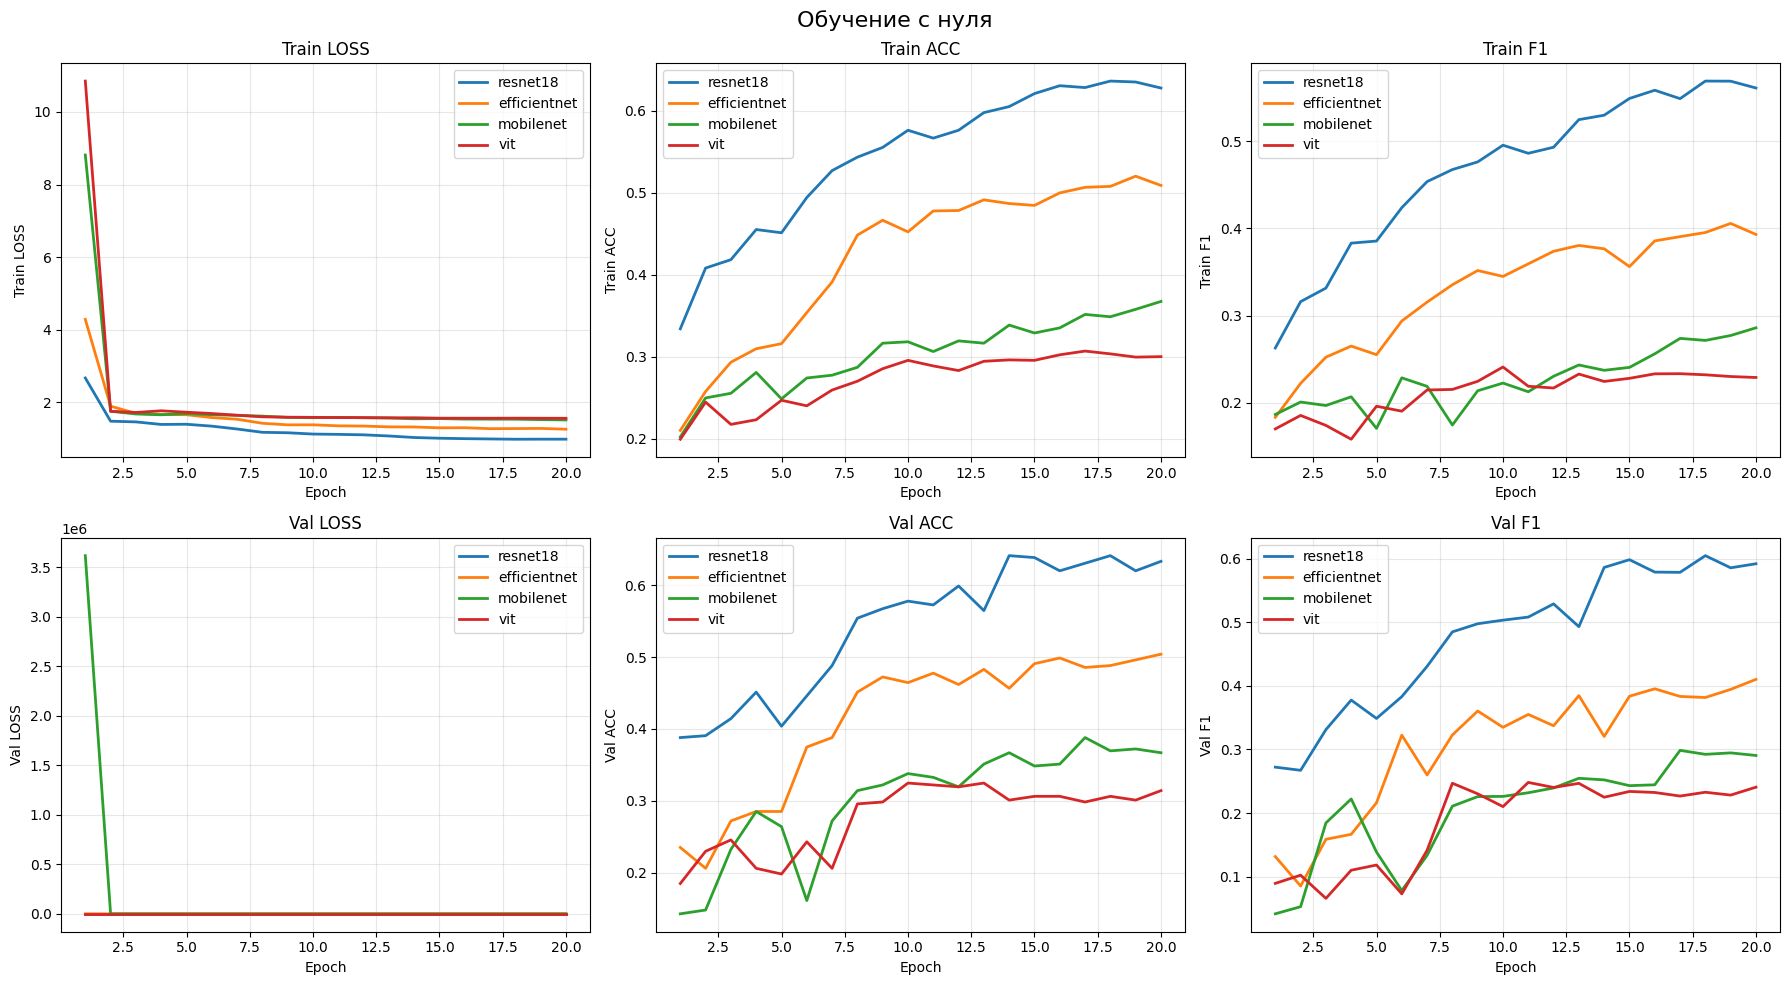


Графики transfer learning:


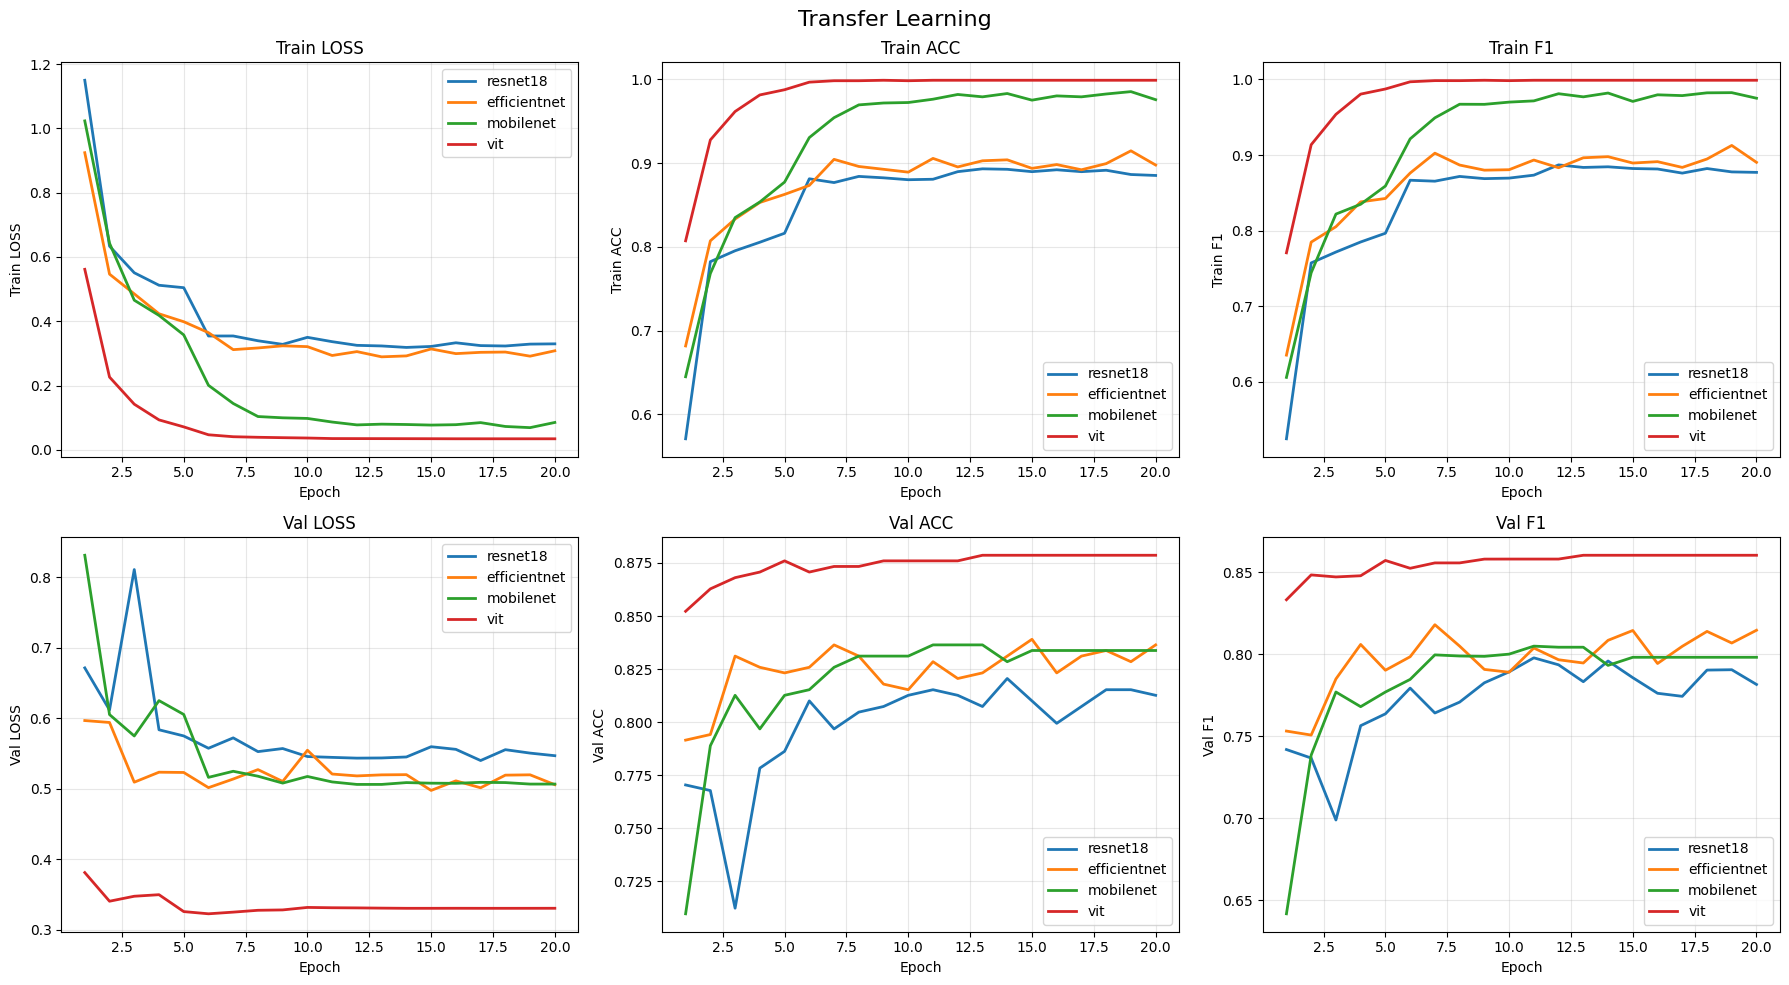

In [6]:
def plot_training_history(histories, title):
    """
    Строит графики обучения для всех моделей
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(title, fontsize=16)

    metrics = ['loss', 'acc', 'f1']
    phases = ['train', 'val']

    for i, metric in enumerate(metrics):
        for j, phase in enumerate(phases):
            ax = axes[j, i]

            for model_name in models_to_test:
                if model_name in histories:
                    key = f'{phase}_{metric}'
                    values = histories[model_name].get(key, [])
                    if values:
                        ax.plot(range(1, len(values) + 1), values, label=model_name, linewidth=2)

            ax.set_xlabel('Epoch')
            ax.set_ylabel(f'{phase.capitalize()} {metric.upper()}')
            ax.set_title(f'{phase.capitalize()} {metric.upper()}')
            ax.legend()
            ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

# %%
# Графики для обучения с нуля
print("\nГрафики обучения с нуля:")
plot_training_history(histories['from_scratch'], 'Обучение с нуля')

# Графики для transfer learning
print("\nГрафики transfer learning:")
plot_training_history(histories['transfer_learning'], 'Transfer Learning')

# %%
# Сравнительная столбчатая диаграмма F1-score
def plot_comparison_bar_chart(results):
    """
    Строит сравнительную столбчатую диаграмму F1-score
    """
    fig, ax = plt.subplots(figsize=(14, 8))

    # Подготовка данных
    model_names = []
    f1_scores = []
    experiment_types = []
    colors = []

    color_palette = plt.cm.Set2(np.linspace(0, 1, len(models_to_test)))

    for i, model_name in enumerate(models_to_test):
        # С нуля
        model_names.append(f'{model_name}\n(с нуля)')
        f1_scores.append(results['from_scratch'][model_name]['f1_score'])
        experiment_types.append('С нуля')
        colors.append(color_palette[i])

        # Transfer learning
        model_names.append(f'{model_name}\n(transfer)')
        f1_scores.append(results['transfer_learning'][model_name]['f1_score'])
        experiment_types.append('Transfer Learning')
        colors.append(color_palette[i])

    # Создаем DataFrame для удобства
    df = pd.DataFrame({
        'Model': model_names,
        'F1-Score': f1_scores,
        'Experiment': experiment_types,
        'Color': colors
    })

    # Строим столбчатую диаграмму
    bars = ax.bar(df['Model'], df['F1-Score'], color=df['Color'], edgecolor='black')

    # Добавляем значения на столбцы
    for bar, score in zip(bars, df['F1-Score']):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{score:.3f}', ha='center', va='bottom', fontsize=10)

    # Настройки графика
    ax.set_xlabel('Модель и тип эксперимента', fontsize=12)
    ax.set_ylabel('Macro F1-Score', fontsize=12)
    ax.set_title('Сравнение Macro F1-Score на тестовом наборе', fontsize=14, fontweight='bold')
    ax.set_ylim([0, 1.1])
    ax.grid(True, axis='y', alpha=0.3)

    # Добавляем легенду
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor=color_palette[i], edgecolor='black', label=models_to_test[i])
        for i in range(len(models_to_test))
    ]
    ax.legend(handles=legend_elements, title='Архитектуры', loc='upper right')

    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    return df


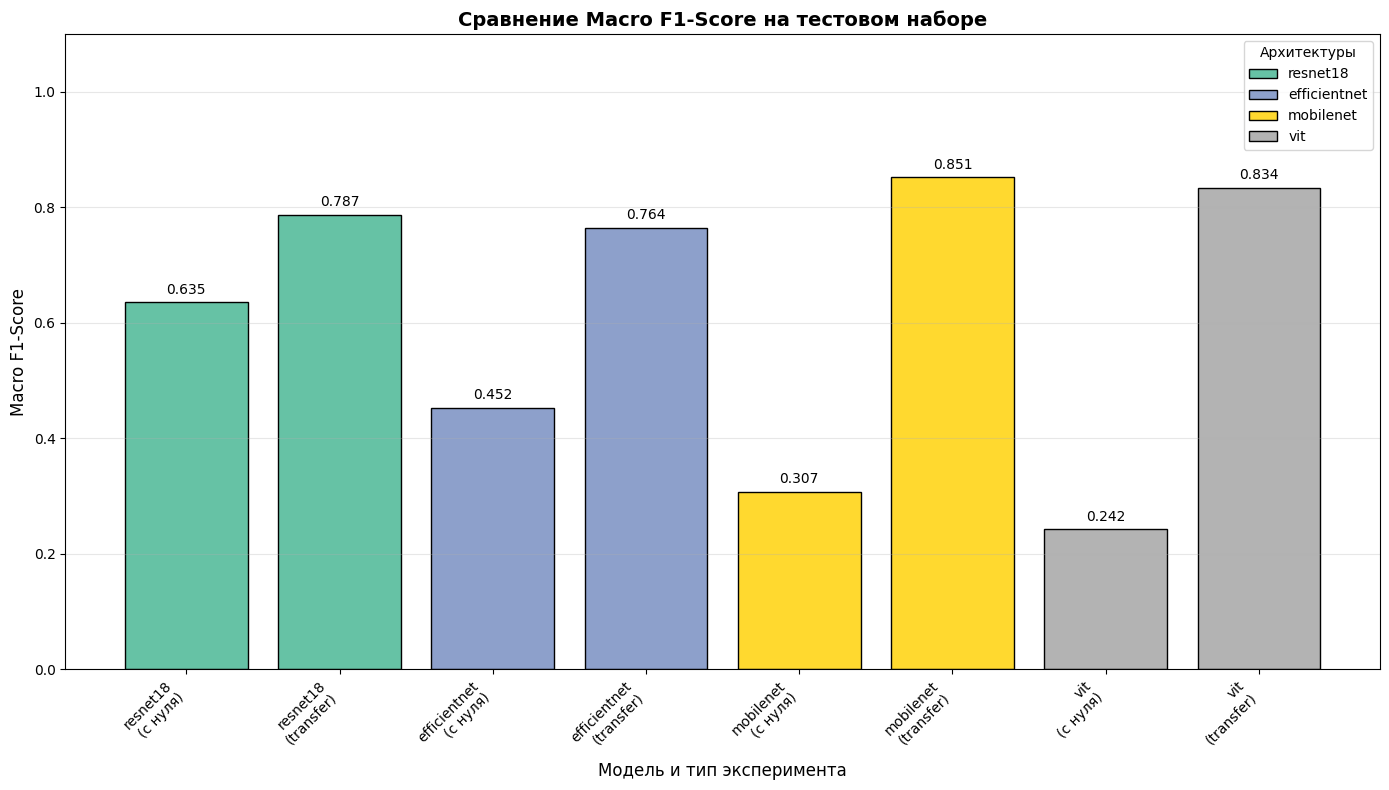


Сводная таблица результатов:
                   Model  F1-Score        Experiment                                                             Color
      resnet18\n(с нуля)  0.635308            С нуля                [0.4, 0.7607843137254902, 0.6470588235294118, 1.0]
    resnet18\n(transfer)  0.786744 Transfer Learning                [0.4, 0.7607843137254902, 0.6470588235294118, 1.0]
  efficientnet\n(с нуля)  0.452112            С нуля  [0.5529411764705883, 0.6274509803921569, 0.796078431372549, 1.0]
efficientnet\n(transfer)  0.763847 Transfer Learning  [0.5529411764705883, 0.6274509803921569, 0.796078431372549, 1.0]
     mobilenet\n(с нуля)  0.306816            С нуля                [1.0, 0.8509803921568627, 0.1843137254901961, 1.0]
   mobilenet\n(transfer)  0.851465 Transfer Learning                [1.0, 0.8509803921568627, 0.1843137254901961, 1.0]
           vit\n(с нуля)  0.242301            С нуля [0.7019607843137254, 0.7019607843137254, 0.7019607843137254, 1.0]
         vit\n(tra

train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 1.0745 Acc: 0.6080 F1: 0.5679


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.6859 Acc: 0.7546 F1: 0.7077

Epoch 2/5
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.6442 Acc: 0.7822 F1: 0.7575


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5917 Acc: 0.8232 F1: 0.7950

Epoch 3/5
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.5485 Acc: 0.8077 F1: 0.7748


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.7124 Acc: 0.7414 F1: 0.7111

Epoch 4/5
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.4316 Acc: 0.8439 F1: 0.8158


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.8248 Acc: 0.7625 F1: 0.6973

Epoch 5/5
--------------------------------------------------


train:   0%|          | 0/56 [00:00<?, ?it/s]

train Loss: 0.4016 Acc: 0.8541 F1: 0.8436


val:   0%|          | 0/12 [00:00<?, ?it/s]

val Loss: 0.5521 Acc: 0.8470 F1: 0.8108

Best val F1: 0.8108


Testing:   0%|          | 0/12 [00:00<?, ?it/s]

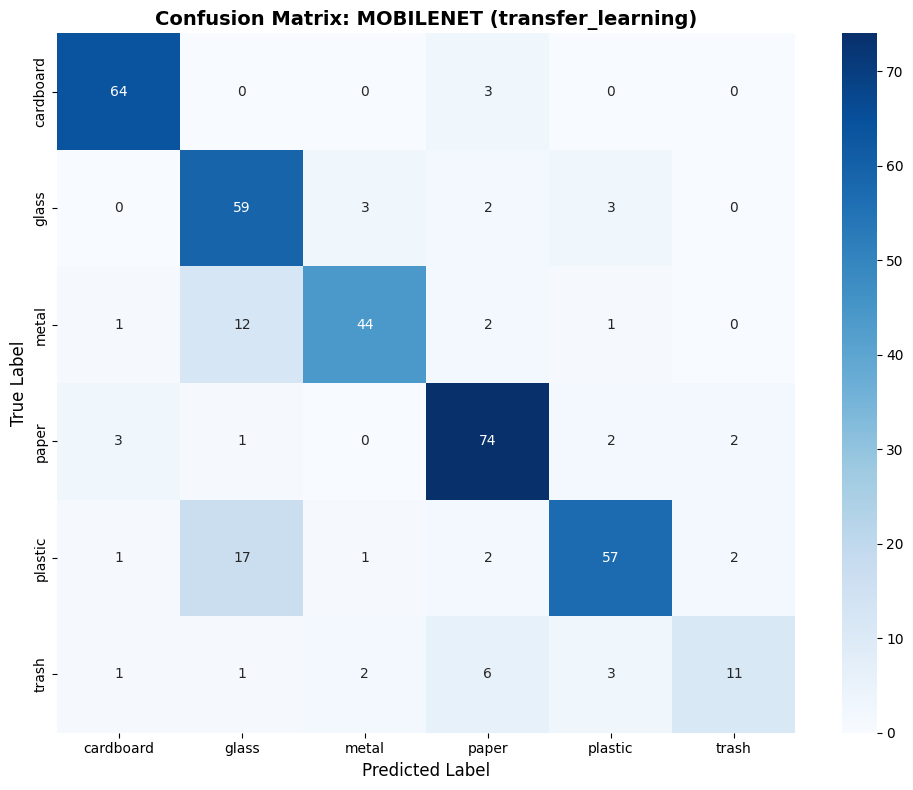


ВЫВОДЫ И ЗАКЛЮЧЕНИЕ

1. СРАВНЕНИЕ АРХИТЕКТУР:
----------------------------------------
Architecture Params (M) F1 Scratch F1 Transfer Improvement %
    RESNET18     ≈11-86     0.6353      0.7867          23.8
EFFICIENTNET     ≈11-86     0.4521      0.7638          69.0
   MOBILENET     ≈11-86     0.3068      0.8515         177.5
         VIT     ≈11-86     0.2423      0.8339         244.2


In [7]:
comparison_df = plot_comparison_bar_chart(results)
print("\nСводная таблица результатов:")
print(comparison_df.to_string(index=False))

# %%
# Анализ улучшений от transfer learning
print("\n" + "=" * 60)
print("АНАЛИЗ УЛУЧШЕНИЙ ОТ TRANSFER LEARNING")
print("=" * 60)

for model_name in models_to_test:
    f1_scratch = results['from_scratch'][model_name]['f1_score']
    f1_transfer = results['transfer_learning'][model_name]['f1_score']
    improvement = ((f1_transfer - f1_scratch) / f1_scratch) * 100

    print(f"\n{model_name.upper()}:")
    print(f"  F1-score (с нуля): {f1_scratch:.4f}")
    print(f"  F1-score (transfer): {f1_transfer:.4f}")
    print(f"  Улучшение: {improvement:+.2f}%")

# %% [markdown]
# ## 8. Дополнительный анализ

# %%
# Confusion Matrix для лучшей модели
print("\n" + "=" * 60)
print("CONFUSION MATRIX ДЛЯ ЛУЧШЕЙ МОДЕЛИ")
print("=" * 60)

# Находим лучшую модель по F1-score
best_f1 = 0
best_model_name = ''
best_experiment_type = ''

for exp_type in ['from_scratch', 'transfer_learning']:
    for model_name in models_to_test:
        f1 = results[exp_type][model_name]['f1_score']
        if f1 > best_f1:
            best_f1 = f1
            best_model_name = model_name
            best_experiment_type = exp_type

print(f"Лучшая модель: {best_model_name} ({best_experiment_type})")
print(f"Лучший F1-score: {best_f1:.4f}")

# %%
# Визуализация confusion matrix для лучшей модели
def plot_confusion_matrix(cm, classes, title='Confusion Matrix'):
    """
    Визуализирует confusion matrix
    """
    fig, ax = plt.subplots(figsize=(10, 8))

    # Используем seaborn для тепловой карты
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=classes, yticklabels=classes,
        ax=ax
    )

    ax.set_xlabel('Predicted Label', fontsize=12)
    ax.set_ylabel('True Label', fontsize=12)
    ax.set_title(title, fontsize=14, fontweight='bold')

    plt.tight_layout()
    plt.show()

# %%
# Обучаем лучшую модель еще раз для получения confusion matrix
print(f"\nОбучаем {best_model_name} ({best_experiment_type}) для анализа...")

if best_experiment_type == 'from_scratch':
    model, _ = create_model(best_model_name, pretrained=False, freeze_backbone=False)
else:
    model, _ = create_model(best_model_name, pretrained=True, freeze_backbone=True)

criterion = nn.CrossEntropyLoss()

if best_experiment_type == 'from_scratch':
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
else:
    trainable_params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = optim.Adam(trainable_params, lr=LEARNING_RATE * 0.1)

# Быстрое обучение для демонстрации
model, _ = train_model(
    model, train_loader, val_loader,
    criterion, optimizer, None,
    num_epochs=5,
    model_name=best_model_name
)

# Получаем confusion matrix
_, _, cm, _ = evaluate_model(model, test_loader)

# Визуализируем confusion matrix
plot_confusion_matrix(
    cm,
    CLASSES,
    title=f'Confusion Matrix: {best_model_name.upper()} ({best_experiment_type})'
)

# %% [markdown]
# ## 9. Выводы и заключение

# %%
print("\n" + "=" * 60)
print("ВЫВОДЫ И ЗАКЛЮЧЕНИЕ")
print("=" * 60)

print("\n1. СРАВНЕНИЕ АРХИТЕКТУР:")
print("-" * 40)

# Создаем DataFrame для сравнения
comparison_data = []
for model_name in models_to_test:
    comparison_data.append({
        'Architecture': model_name.upper(),
        'Params (M)': '≈11-86',  # Приблизительное количество параметров
        'F1 Scratch': f"{results['from_scratch'][model_name]['f1_score']:.4f}",
        'F1 Transfer': f"{results['transfer_learning'][model_name]['f1_score']:.4f}",
        'Improvement %': f"{((results['transfer_learning'][model_name]['f1_score'] - results['from_scratch'][model_name]['f1_score']) / results['from_scratch'][model_name]['f1_score'] * 100):.1f}"
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))
